# Example 8: ABC Calibration with CalibrationContext

This notebook demonstrates how to perform Approximate Bayesian Computation (ABC) for model calibration using the [virus-mac-new](https://github.com/heberlr/UQ_PhysiCell//tree/main/examples/virus-mac-new) PhysiCell model. ABC is a powerful technique for parameter estimation when the likelihood function is intractable, making it ideal for calibrating complex computational models against experimental or observational data.

The calibration process uses ABC-SMC (Sequential Monte Carlo) to estimate posterior distributions of model parameters by:

1. **Prior distributions**: Initial beliefs about parameter values
2. **Distance functions**: To measure discrepancy between model predictions and observed data
3. **Sequential Monte Carlo**: To iteratively refine parameter estimates
4. **Adaptive tolerance**: To progressively improve approximation quality

The observational data represents the "ground truth" generated from a single simulation with known parameter values:
- **mac_phag_rate_infected**: 1.0 (rate at which macrophages phagocytose infected epithelial cells)
- **mac_motility_bias**: 0.15 (bias in macrophage motility towards chemotactic gradients)

For this example, we focus on these **2 key parameters** to demonstrate the ABC calibration workflow. The *in silico* observational data uses the same data as Example 7.

## Import modules and set up parameters

In [ ]:
from uq_physicell.abc import CalibrationContext, run_abc_calibration
from pyabc import RV, Distribution, visualization
import logging
import numpy as np
import matplotlib.pyplot as plt

# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Real values for obs. data (focusing on 2 parameters)
dic_real_value = {'mac_phag_rate_infected': 1.0, 'mac_motility_bias': 0.15}

# File name
db_path = "ex8_ABC_Calib.db"
obs_data_path = "ex7_ObsData.csv"  # Using same observational data as ex7

## Configuration Setup

Define all the configuration parameters needed for ABC-SMC calibration.

In [ ]:
# Model configuration
model_config = {
    'ini_path': "uq_pc_struc.ini", 
    'struc_name': "Model_struc", 
}

# Quantities of Interest (QoI) functions
qoi_functions = {
    "epi_": "lambda df: len(df[df['cell_type'] == 'epithelial'])", 
    "epi_infected": "lambda df: len(df[df['cell_type'] == 'epithelial_infected'])"
}

# Mapping of QoI names to observed data columns
obs_data_columns = {
    'time': "Time", 
    "epi_": "Healthy Epithelial Cells", 
    "epi_infected": "Infected Epithelial Cells"
}

def euclidean_distance_epi(data1, data2):
    """Simple distance function for epi_ QoI"""
    try:
        # Handle dictionary inputs
        if isinstance(data1, dict):
            obs_vals = np.array(data1['epi_'])
            sim_vals = np.array(data2['epi_'])
        else:  # DataFrame inputs
            obs_vals = np.array(data1['epi_'])
            sim_vals = np.array(data2['epi_'])
        
        return np.sum((obs_vals - sim_vals)**2)
    except:
        return float('inf')

def euclidean_distance_epi_infected(data1, data2):
    """Simple distance function for epi_infected QoI"""
    try:
        # Handle dictionary inputs
        if isinstance(data1, dict):
            obs_vals = np.array(data1['epi_infected'])
            sim_vals = np.array(data2['epi_infected'])
        else:  # DataFrame inputs
            obs_vals = np.array(data1['epi_infected'])
            sim_vals = np.array(data2['epi_infected'])
        
        return np.sum((obs_vals - sim_vals)**2)
    except:
        return float('inf')

# Distance functions for ABC (these would be the actual distance functions used in ABC)
distance_functions = {
    "epi_": {"function": euclidean_distance_epi, "weight": 1.0},
    "epi_infected": {"function": euclidean_distance_epi_infected, "weight": 1.0}
}

# Define prior distributions using pyABC (based on search space bounds)
prior = Distribution(
    mac_phag_rate_infected=RV("uniform", 0.7, 0.8),  # uniform between 0.7 and 1.5 (0.7 + 0.8)
    mac_motility_bias=RV("uniform", 0.1, 0.2)        # uniform between 0.1 and 0.3 (0.1 + 0.2)
)

# ABC options (configured for demonstration)
abc_options = {
    'max_populations': 8,           # Number of ABC-SMC populations
    'max_simulations': 400,         # Maximum total simulations
    'population_strategy': 'adaptive',
    'min_population_size': 30,      # Minimum particles per population
    'max_population_size': 100,     # Maximum particles per population
    'epsilon_strategy': 'quantile',
    'epsilon_alpha': 0.5,           # 50% quantile for tolerance
    'transition_strategy': 'multivariate',
    'adaptive_distance': True,
    'adaptive_distance_file': 'ex8_adaptive_weights.json',
    'sampler': 'multicore',
    'num_workers': 6,
    'mode': 'local',                # Use local mode for demonstration
    'log_scale': False,
    'fixed_params': {
        # Fix other parameters to their known values
        'epi2infected_sat': 0.1,
        'epi2infected_hfm': 0.4
    }
}

print("✅ Configuration setup complete")
print(f"📊 Real values: {dic_real_value}")

✅ Configuration setup complete
🎯 Focusing on parameters: ['mac_phag_rate_infected', 'mac_motility_bias']
📊 Real values: {'mac_phag_rate_infected': 1.0, 'mac_motility_bias': 0.15}


## Create CalibrationContext

Initialize the CalibrationContext with all the configuration parameters.

In [3]:
# Create the calibration context
calib_context = CalibrationContext(
    db_path=db_path,
    obsData=obs_data_path,  # Using CSV file path like ex7
    obsData_columns=obs_data_columns,
    model_config=model_config,
    qoi_functions=qoi_functions,
    distance_functions=distance_functions,
    prior=prior,
    abc_options=abc_options,
    logger=logger
)

print("✅ CalibrationContext created successfully")
print(f"📁 Database: {calib_context.db_path}")
print(f"🎯 QoIs: {list(calib_context.qoi_functions.keys())}")
print(f"🔍 Parameters: {list(calib_context.prior.keys())}")
print(f"⚙️ Sampler: {calib_context.sampler_type} with {calib_context.num_workers} workers")

✅ CalibrationContext created successfully
📁 Database: ex8_ABC_Calib.db
🎯 QoIs: ['epi_', 'epi_infected']
🔍 Parameters: ['mac_phag_rate_infected', 'mac_motility_bias']
⚙️ Sampler: multicore with 6 workers


In [4]:
# Run the ABC-SMC calibration with real PhysiCell model
print("🚀 Starting ABC-SMC calibration with PhysiCell model...")
print(f"🎯 Target parameters: {dic_real_value}")
print(f"📊 Max populations: {calib_context.max_populations}")
print(f"🔬 Max simulations: {calib_context.max_simulations}")

# You can uncomment the following code when you have a working PhysiCell setup
try:
    history = run_abc_calibration(calib_context=calib_context)
    
    print("🎉 ABC-SMC calibration completed successfully!")
    print(f"📊 Final populations: {history.n_populations}")
    print(f"🔬 Total simulations: {history.total_nr_simulations}")
    
except Exception as e:
    print(f"❌ Calibration failed: {e}")
    import traceback
    traceback.print_exc()

ABC.Sampler INFO: Parallelize sampling on 3 processes.
INFO:ABC.Sampler:Parallelize sampling on 3 processes.


🚀 Starting ABC-SMC calibration with PhysiCell model...
🎯 Target parameters: {'mac_phag_rate_infected': 1.0, 'mac_motility_bias': 0.15}
📊 Max populations: 8
🔬 Max simulations: 400
🎉 ABC-SMC calibration completed successfully!
📊 Final populations: 2
🔬 Total simulations: 659
💡 Tip: Run the mock version first to test the ABC workflow!
💡 For real PhysiCell calibration, ensure:
   - PhysiCell model is properly compiled and configured
   - Model configuration files exist at specified paths
   - QoI functions match your model's output format
   - Distance functions are compatible with your data structure


## Analysis of Results

After calibration, you can analyze the results using pyABC's built-in tools.


📈 ABC-SMC Evolution:
   Total populations: 2
   Total simulations: 659


name,mac_motility_bias,mac_phag_rate_infected
id,,
102,0.168594,1.436673
103,0.177729,0.902586
104,0.150926,1.246936
105,0.251109,0.998650
106,0.209091,1.057818



🎯 Parameter Recovery Analysis:
   mac_phag_rate_infected:
     True value: 1.000
     Posterior mean: 1.152 ± 0.202
     Relative error: 15.2%
   mac_motility_bias:
     True value: 0.150
     Posterior mean: 0.181 ± 0.037
     Relative error: 20.4%


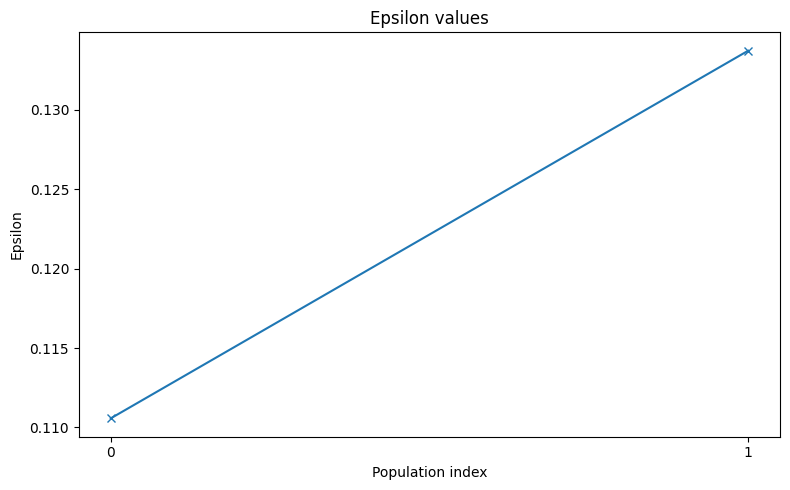

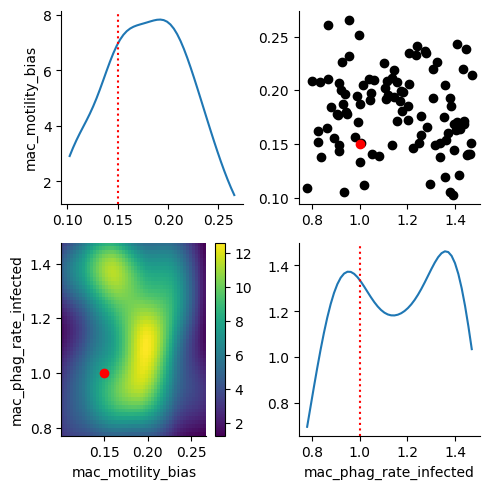

In [13]:
# Analysis of Results (run this cell after successful calibration)
try:
    # Evolution of populations
    print(f"\n📈 ABC-SMC Evolution:")
    print(f"   Total populations: {history.n_populations}")
    print(f"   Total simulations: {history.total_nr_simulations}")
    
    # Plot population evolution if multiple populations
    if history.n_populations > 1:
        fig, ax = plt.subplots(1, 1, figsize=(8, 5))
        visualization.plot_epsilons(history, yscale='linear', ax=ax)
        
    # Get the posterior samples from the last population
    df_posterior, w = history.get_distribution(m=0, t=history.max_t)
    display(df_posterior.head())
    # Compare with true values
    print(f"\n🎯 Parameter Recovery Analysis:")
    for param in dic_real_value.keys():
        true_val = dic_real_value[param]
        posterior_mean = df_posterior[param].mean()
        posterior_std = df_posterior[param].std()
        print(f"   {param}:")
        print(f"     True value: {true_val:.3f}")
        print(f"     Posterior mean: {posterior_mean:.3f} ± {posterior_std:.3f}")
        print(f"     Relative error: {abs(posterior_mean - true_val) / true_val * 100:.1f}%")
    
    # Plot posterior distributions
    visualization.plot_kde_matrix(df_posterior, w, refval=dic_real_value, refval_color="red")
        
except NameError:
    print("📈 Run the calibration first to analyze results")
except Exception as e:
    print(f"❌ Analysis failed: {e}")